<a href="https://colab.research.google.com/github/bismark021/Bisfun/blob/main/Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('drive/MyDrive/Insurance Project/archive(1)/train/train/train.csv')

# Step 2: Define the mapping for the labels
label_mapping = {
    1: 'crack',
    2: 'scratch',
    3: 'tire flat',
    4: 'dent',
    5: 'glass shatter',
    6: 'lamp broken'
}

# Step 3: Update labels in the DataFrame
train_data['label'] = train_data['label'].map(label_mapping)

# Step 4: Split the training data into 80% train and 20% validation
train_data_split, val_data_split = train_test_split(train_data, test_size=0.2, random_state=42)


image_dir = ('drive/MyDrive/Insurance Project/archive(1)/train/train/images')

# Step 6: Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [3]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data_split,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data_split,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

def visualize_images_per_class(dataframe, num_images_per_class=5):
    classes = dataframe['label'].unique()
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(classes):
        class_data = dataframe[dataframe['label'] == class_name]
        selected_images = class_data.sample(n=min(num_images_per_class, len(class_data)))

        for j, row in enumerate(selected_images.itertuples()):
            img_path = os.path.join(image_dir, row.filename)
            img = plt.imread(img_path)
            plt.subplot(len(classes), num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

Found 5760 validated image filenames belonging to 6 classes.
Found 1440 validated image filenames belonging to 6 classes.


In [4]:
from keras.applications import imagenet_utils
from keras.applications import mobilenet
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define input shape
input_shape = (150, 150, 3)  # Assuming image size is (150, 150)

# Number of classes (6 types of damage)
num_classes = 6

In [5]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom classification layers
x = base_model_resnet.output
x = Flatten()(x)  # ResNet50 does not require GlobalAveragePooling if you're using Flatten
x = Dense(1024, activation='elu')(x)
x = Dense(1024, activation='elu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model_resnet.layers[-10:]:  # Unfreeze last 10 layers of ResNet50
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to check the architecture
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 77,073,286 (294.01 MB)

 Trainable params: 77,020,166 (293.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Define where you want to save the checkpoints
checkpoint_filepath = '/content/checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,  # Path to save the model
    save_weights_only=True,        # Saves only the weights (smaller files)
    monitor='val_loss',            # Monitor validation loss
    mode='min',                    # Save the model with the minimum val_loss
    save_best_only=False,          # Saves the model after every epoch
    verbose=1                      # Logs when checkpoints are saved
)

# Train the model with the checkpoint callback
history_finetune_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint_callback]  # Include the checkpoint callback
)


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.4722 - loss: 1.5555 
Epoch 1: saving model to /content/checkpoints/model_epoch_01_val_loss_4.38.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 6560s 35s/step - accuracy: 0.4728 - loss: 1.5537 - val_accuracy: 0.2799 - val_loss: 4.3759
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7025 - loss: 0.7959
Epoch 2: saving model to /content/checkpoints/model_epoch_02_val_loss_2.51.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 149s 616ms/step - accuracy: 0.7026 - loss: 0.7958 - val_accuracy: 0.2688 - val_loss: 2.5101
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7682 - loss: 0.6098
Epoch 3: saving model to /content/checkpoints/model_epoch_03_val_loss_2.06.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 140s 614ms/step - accuracy: 0.7682 - loss: 0.6097 - val_accuracy: 0.3118 - val_loss: 2.0610
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7989 - loss: 0.5071
Epoch 4: saving model to /con

In [9]:
 #Save the model to a file
model_resnet.save('my_model_resnet.h5')  # Save as an HDF5 file

Training Accuracy: 0.9247
Validation Accuracy: 0.8840
Training Loss: 0.2117
Validation Loss: 0.3321




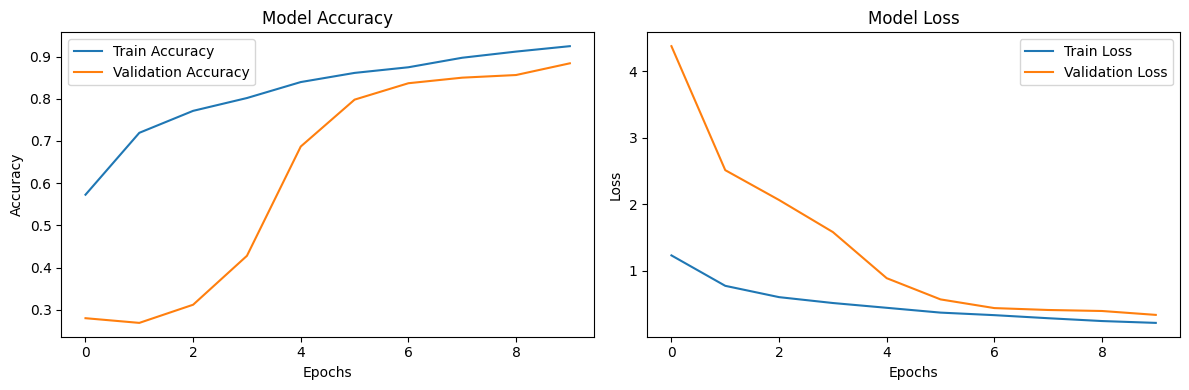

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot training history
def plot_history(history):
    # Print final train and validation accuracies and losses
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Training Accuracy: {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print("\n========================================\n")

    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot training history
plot_history(history_finetune_resnet)

In [23]:
from tensorflow.keras.preprocessing import image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Resize the image to 224x224 for ResNet50
    img_array = image.img_to_array(img)  # Convert the image to a NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension to make it (1, 224, 224, 3)
    img_array = img_array / 255.0  # Rescale pixel values to [0, 1]
    return img_array

In [24]:
unseen_image_path = 'drive/MyDrive/dent image.jpg'  # Replace with your image path
preprocessed_image = preprocess_image(unseen_image_path)

In [25]:
predictions = model_resnet.predict(preprocessed_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [28]:
class_names = {
    0: 'crack',
    1: 'dent',
    2: 'other',
    3: 'rim',
    4: 'scratch',
}

In [29]:
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class = class_names[predicted_class_index]

In [30]:
print(f'Predicted class: {predicted_class}')

Predicted class: dent


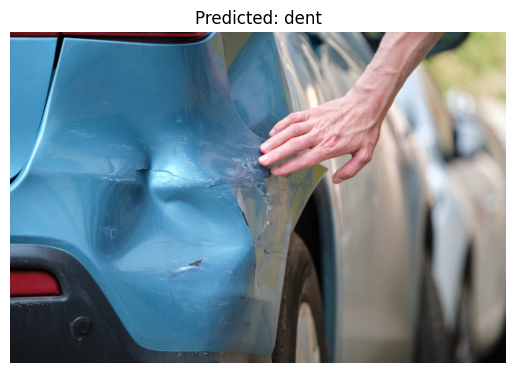

In [32]:
plt.imshow(image.load_img(unseen_image_path))
plt.title(f'Predicted: {predicted_class}')
plt.axis('off')
plt.show()